In [1]:
from glob import glob
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import matplotlib.font_manager as fm
plt.rc('font', family='AppleGothic') # for MAC OS users
#plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user

In [2]:
lst_data = glob('../../3. 에포크_데이터 및 모델 세이브 파일/data/*.csv')
var_data = ['cust_demo', 'prod_buy', 'service_use', 'prod_cat', 'partner', 'lpay']
for name, file in zip(var_data, lst_data):
    globals()[name] = pd.read_csv(file)

/var/folders/ty/d0l26xd500q6hk3ryfccwjy00000gn/T/ipykernel_8720/2033872303.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[name] = pd.read_csv(file)


In [4]:
prod_buy = prod_buy[['cust', 'rct_no', 'cop_c', 'br_c', 'chnl_dv', 'de_dt', 'de_hr', 'buy_am']]
service_use = service_use[['cust', 'rct_no', 'cop_c', 'br_c', 'chnl_dv', 'de_dt', 'de_hr', 'buy_am']]

all_df = pd.concat([prod_buy , service_use ] , axis = 0) ; all_df

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,de_hr,buy_am
0,M430112881,A01000001113,A01,A010039,1,20210101,10,15000.0
1,M646853852,A01000002265,A01,A010025,1,20210101,10,79700.0
2,M430112881,A01000003148,A01,A010039,1,20210101,10,19000.0
3,M430112881,A01000003148,A01,A010039,1,20210101,10,19000.0
4,M430112881,A01000004946,A01,A010039,1,20210101,10,19000.0
...,...,...,...,...,...,...,...,...
248299,M058650684,21111614C021426818,C02,C020002,1,20211116,14,2000.0
248300,M058650684,21111619C023223432,C02,C020002,1,20211116,19,26900.0
248301,M014154595,21121209C015324520,C01,C010087,2,20211212,9,2000.0
248302,M510878172,21112719C013369102,C01,C010007,2,20211127,19,6000.0


In [5]:
all_df['de_dt'] = pd.to_datetime(all_df['de_dt'].astype('str'))

# 최종 구매일 다음날을 기준으로 계산 
now = all_df.de_dt.max()+pd.DateOffset(days=1)

# method chaining (multi-line)
recency = (all_df.groupby('cust')['de_dt']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'recency'}))

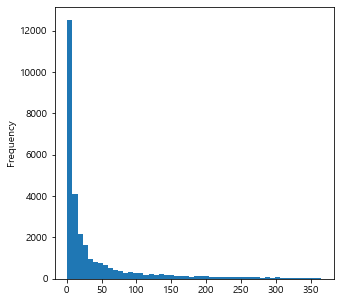

In [6]:
plt.figure(figsize=(5,5))
recency.recency.plot.hist(bins=50)
plt.show()

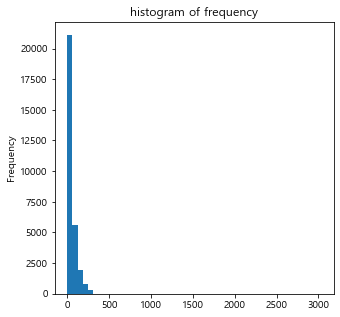

In [7]:
frequency =  all_df.groupby('cust')['rct_no'].agg([('frequency', Series.nunique)]).reset_index()

plt.figure(figsize=(5,5))
frequency.frequency.plot.hist(bins=50, title='histogram of frequency')
plt.show()

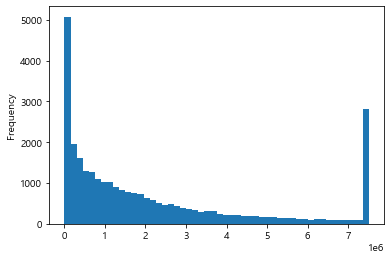

In [8]:
monetary = all_df.groupby('cust')['buy_am'].agg([('monetary', np.sum)]).reset_index()
IQR = monetary['monetary'].quantile(0.75) - monetary['monetary'].quantile(0.25)
line_down = monetary['monetary'].quantile(0.75) - IQR*1.5
line_up = monetary['monetary'].quantile(0.75) + IQR*1.5

monetary['monetary'] = monetary['monetary'].clip(line_down, line_up )

monetary.monetary.plot.hist(bins=50)
plt.show()

<AxesSubplot:xlabel='RFMgroup', ylabel='count'>

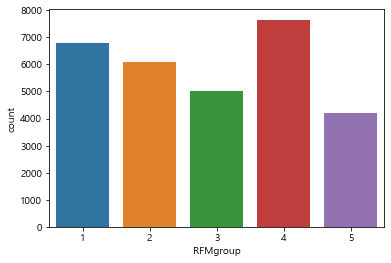

In [9]:
rfm = recency.merge(frequency).merge(monetary)
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=range(1,6)).astype(int)
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=range(1,6)).astype(int)
rfm['RFMgroup'] = (rfm['R']+ rfm['F']+ rfm['M'])
rfm['RFMgroup'] = pd.qcut(rfm['RFMgroup'], q=5, labels=range(1,6)).astype(int)
sns.countplot( x = 'RFMgroup' , data = rfm ) 

In [10]:
rfm = rfm[['cust' , 'RFMgroup']]
all_df = all_df.merge(rfm) ; all_df

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,de_hr,buy_am,RFMgroup
0,M430112881,A01000001113,A01,A010039,1,2021-01-01,10,15000.0,5
1,M430112881,A01000003148,A01,A010039,1,2021-01-01,10,19000.0,5
2,M430112881,A01000003148,A01,A010039,1,2021-01-01,10,19000.0,5
3,M430112881,A01000004946,A01,A010039,1,2021-01-01,10,19000.0,5
4,M430112881,A01000005297,A01,A010039,1,2021-01-01,10,9900.0,5
...,...,...,...,...,...,...,...,...,...
4630042,M461320805,21081215C012742314,C01,C010120,2,2021-08-12,15,42000.0,1
4630043,M094511286,21112413D014417246,D01,D010528,1,2021-11-24,13,14120.0,1
4630044,M736929241,21091422C014625802,C01,C010011,2,2021-09-14,22,26000.0,1
4630045,M040608978,21102916C024520111,C02,C020002,1,2021-10-29,16,27500.0,1


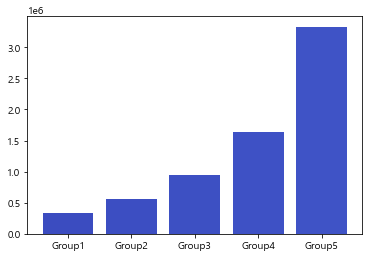

In [11]:
buy_am = []
for i in range(1,6) : 
    cust_uni = all_df.query('RFMgroup == @i ')['cust'].unique()
    cust_buy_am = lpay.query('cust in @cust_uni').groupby('cust')['buy_am'].sum().reset_index()
    IQR = cust_buy_am['buy_am'].quantile(0.75) - cust_buy_am['buy_am'].quantile(0.25)
    line_down = cust_buy_am['buy_am'].quantile(0.75) - IQR*1.5
    line_up = cust_buy_am['buy_am'].quantile(0.75) + IQR*1.5
    cust_buy_am['buy_am'] = cust_buy_am['buy_am'].clip(line_down, line_up )
    buy_am.append( cust_buy_am['buy_am'].mean())

    
colors = cm.get_cmap('coolwarm')(np.arange(5)) 
x = np.arange(5)
plt.bar(x, buy_am , color = colors)
plt.xticks(x, [ 'Group'+str(i) for i in range(1,6)])

plt.show()

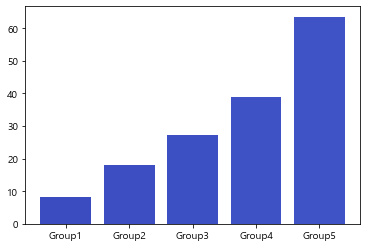

In [12]:
buy_count = []
for i in range(1,6) : 
    cust_uni = all_df.query('RFMgroup == @i ')['cust'].unique()
    mean_buy_am = lpay.query('cust in @cust_uni').groupby('cust')['buy_am'].count().reset_index()
    buy_count.append( mean_buy_am['buy_am'].mean())

colors = cm.get_cmap('coolwarm')(np.arange(5)) 
x = np.arange(5)
plt.bar(x, buy_count , color = colors )
plt.xticks(x, [ 'Group'+str(i) for i in range(1,6)])

plt.show()